In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

In [3]:
df= pd.read_csv('D:\downloads\insurance.csv')
df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Input variables:

1. age - the age of the person <br/>
2. sex - male or female <br/>
3. bmi - The ratio of height to weight of a person less than 18.5 = underweight 18.5-25 = normal range 25-30 = overwight more than 30 = obse <br/>
4. children - How many children does the insured have? <br/>
5. smoker - Whether the person smokes or does not smoke <br/>
6. region - The area where the person lives <br/>

Output Variable:<br/>

charges: How much does a person pay for insurance

In [4]:
# as we can see we dont have any null data
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
#We will check how many duplicate rowes we have
df.duplicated().sum()

1

In [6]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


the mean of the bmi its 30 we can undrsatnd from that that many pepole have obse we will show the effcts later

In [7]:
from sklearn.preprocessing import LabelEncoder
#sex
le = LabelEncoder()
le.fit(df.sex.drop_duplicates()) 
df.sex = le.transform(df.sex)
# smoker or not
le.fit(df.smoker.drop_duplicates()) 
df.smoker = le.transform(df.smoker)
#region
le.fit(df.region.drop_duplicates()) 
df.region = le.transform(df.region)

In [8]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


In [9]:
df.describe()

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,1.515695,13270.422265
std,14.049960,0.500160,6.098187,1.205493,0.403694,1.104885,12110.011237
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.296250,0.000000,0.000000,1.000000,4740.287150
50%,39.000000,1.000000,30.400000,1.000000,0.000000,2.000000,9382.033000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,2.000000,16639.912515
max,64.000000,1.000000,53.130000,5.000000,1.000000,3.000000,63770.428010


In [10]:
#lets try to understand which variables have the bigst impct on charges
df.corr()['charges'].sort_values()

region     -0.006208
sex         0.057292
children    0.067998
bmi         0.198341
age         0.299008
smoker      0.787251
charges     1.000000
Name: charges, dtype: float64

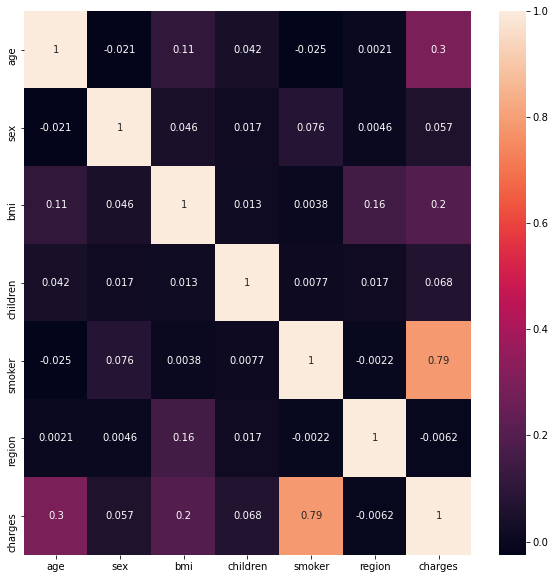

In [11]:
cormap = df.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cormap, annot = True)

As can be seen from the heat map the values that have the maximum impact on charges are:<br/>
1. smoker:0.79<br/>
2. age:0.3<br/>
3. bmi:0.2<br/>

Surprisingly the bmi has a relatively minor effect on charges 

Lets try to understand a bit more the impct of some of are valus on charges

## BMI effects

In [12]:
#add obese culmn 
bins = (0, 29.9999999, 53.13)
labels = ['not_obese', 'obese']
df['obese'] = pd.cut(x =df['bmi'], bins = bins, labels = labels)
df['obese'].value_counts()

obese        707
not_obese    631
Name: obese, dtype: int64

In [13]:
df['obese'] = le.fit_transform(df['obese'])

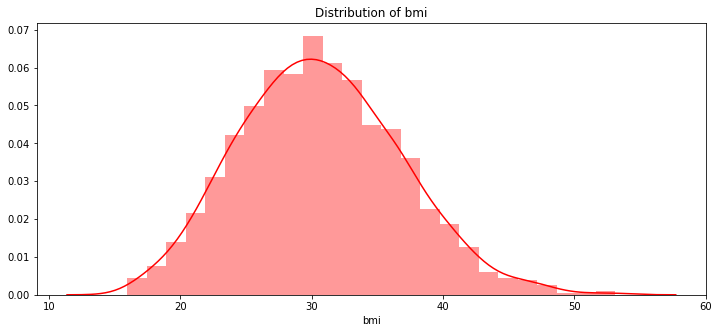

In [14]:
plt.figure(figsize=(12,5))
plt.title("Distribution of bmi")
ax = sns.distplot(df["bmi"], color = 'r')

We will illustrate how much obesity affects the charges

In [15]:
obese_charges=df[['obese','charges']].groupby(['obese']).describe()
obese_charges

charges                                                                \
        count          mean           std        min        25%         50%   
obese                                                                         
0       631.0  10713.666901   7843.536999  1121.8739  4436.6788  8604.48365   
1       707.0  15552.335469  14552.321382  1131.5066  5194.6588  9964.06000   

                                  
                75%          max  
obese                             
0      14850.087900  38245.59327  
1      20068.166695  63770.42801

It can be seen that the average charge increases by almost $ 5,000 for someone who is obese

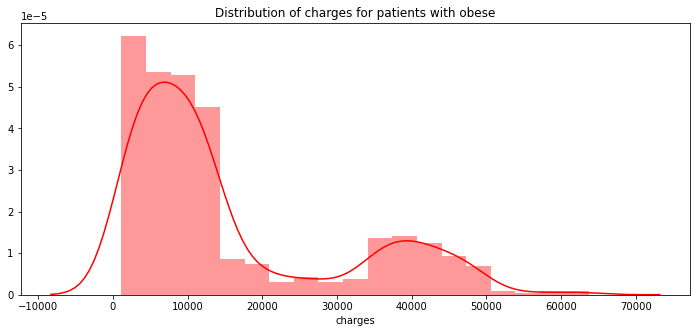

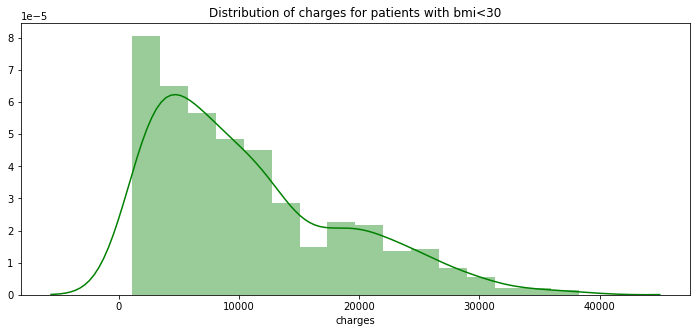

In [16]:
plt.figure(figsize=(12,5))
plt.title("Distribution of charges for patients with obese")
ax = sns.distplot(df[(df.bmi >= 30)]['charges'], color = 'r')
plt.figure(figsize=(12,5))
plt.title("Distribution of charges for patients with bmi<30")

ax = sns.distplot(df[(df.bmi < 30)]['charges'], color = 'g')

## Smoking effects

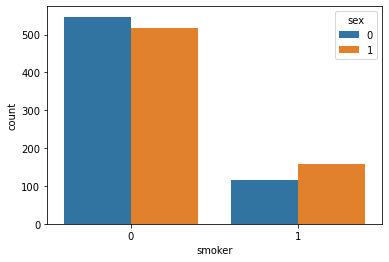

In [17]:
# smoker by sex
sns.countplot(x='smoker',hue = 'sex', data=df)

In [18]:
smoker_charges=df[['smoker','charges']].groupby(['smoker']).describe()
smoker_charges

charges                                                        \
         count          mean           std         min           25%   
smoker                                                                 
0       1064.0   8434.268298   5993.781819   1121.8739   3986.438700   
1        274.0  32050.231832  11541.547176  12829.4551  20826.244213   

                                                
                50%           75%          max  
smoker                                          
0        7345.40530  11362.887050  36910.60803  
1       34456.34845  41019.207275  63770.42801

wow that crazy the mean charges for a somker its allmost 4 time the mean charges of no smoker person

Text(0.5, 1.0, 'Distribution of charges for non-smokers')

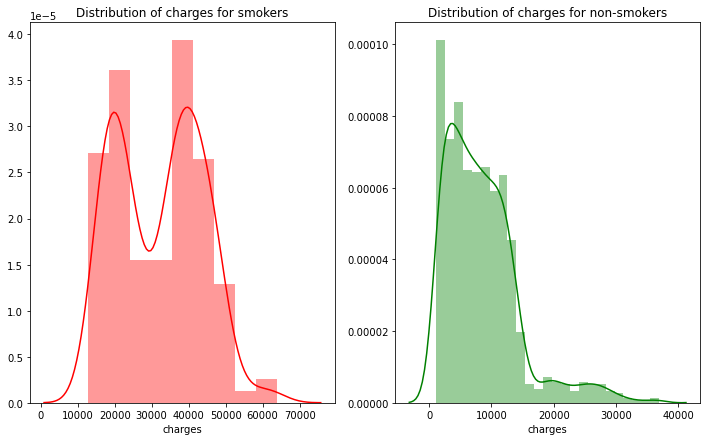

In [19]:
f= plt.figure(figsize=(12,7))

ax=f.add_subplot(121)
sns.distplot(df[(df.smoker == 1)]["charges"],color='r',ax=ax)
ax.set_title('Distribution of charges for smokers')

ax=f.add_subplot(122)
sns.distplot(df[(df.smoker == 0)]['charges'],color='g',ax=ax)
ax.set_title('Distribution of charges for non-smokers')

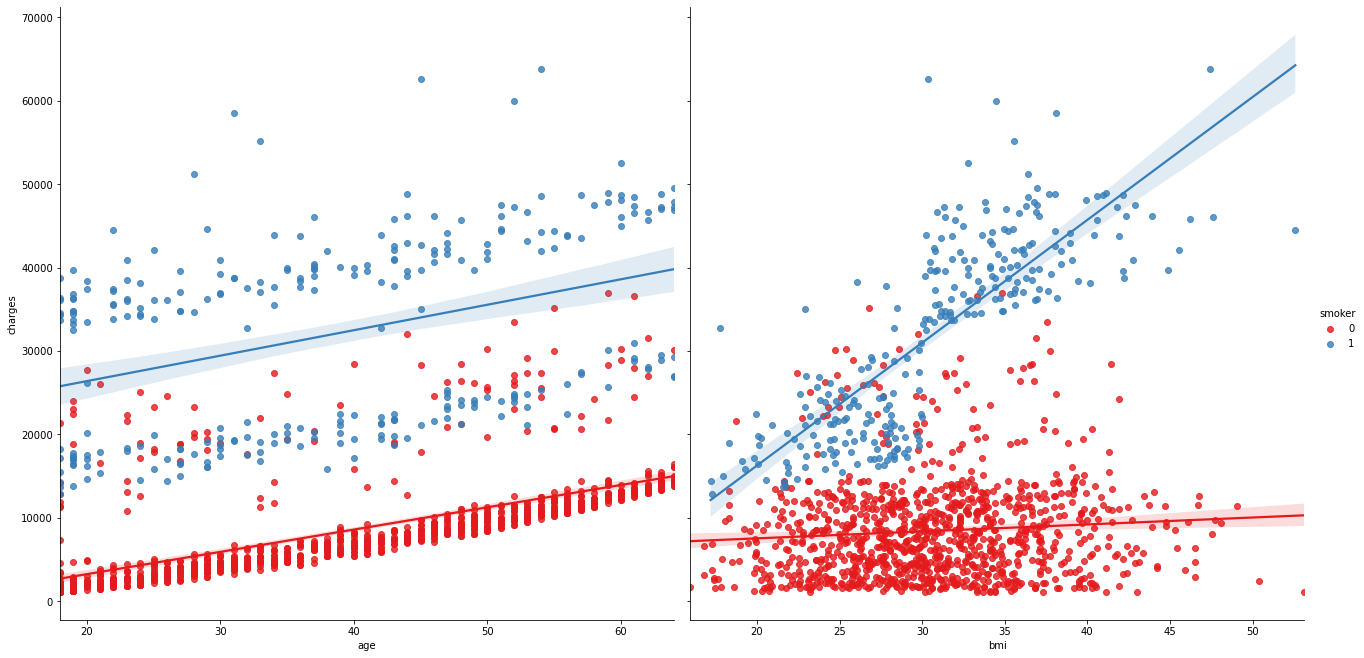

In [162]:
# visualize the relationship between the features and the response using scatterplots
sns.pairplot(df, x_vars=['age', 'bmi',], y_vars='charges',hue='smoker', palette='Set1', height=9,  kind='reg')

we can see we have outliars so we need to use standard scaler to deal with that 

# Model

In [134]:
df.head()

,age,sex,bmi,children,smoker,region,charges,obese
0,19,0,27.900,0,1,3,16884.92400,0
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,1
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,0


In [20]:
X = df[['age', 'bmi', 'smoker', 'sex','children','region','obese']] 
y = df['charges']


In [21]:
from sklearn.model_selection import train_test_split
rc = RobustScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train = rc.fit_transform(X_train)
X_test = rc.transform(X_test)

# Dummy

In [22]:
dummy_regr_median = DummyRegressor(strategy="median")
dummy_regr_median.fit(X_train, y_train)
y_pred = dummy_regr_median.predict(X_test)
err_dummy_meadian = mean_squared_error(y_test,dummy_regr_median.predict(X_test), squared=False)
initial_prediction_dm_median = dummy_regr_median.predict(X_test)

print("R2 Score:",metrics.r2_score(y_test, y_pred))
print ("Mean Square ERR:",mean_squared_error(y_test,dummy_regr_median.predict(X_test), squared=False))

R2 Score: -0.10598651494667877
Mean Square ERR: 13266.333044675308


# Linear regression

In [23]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
initial_prediction_lr = linear_reg.predict(X_test)

print("R2 Score:",linear_reg.score(X_test,y_test))
print("Mean Square ERR:",mean_squared_error(y_test,initial_prediction_lr, squared=False))

R2 Score: 0.8010772163332307
Mean Square ERR: 5626.2398695670045


### Cross validation

In [141]:
linear_reg_scores = cross_val_score(LinearRegression(),X_train, y_train,cv=5,scoring="neg_mean_squared_error", )
linear_reg_scores_r2 = cross_val_score(LinearRegression(),X_train, y_train,cv=5,scoring="r2")

#print(linear_reg_scores)
#print(linear_reg_scores_r2)

print("After cross validation:\n")
print("R2 Score:",linear_reg_scores_r2.mean())
print ("Mean Square ERR:",np.sqrt(-linear_reg_scores.mean()))

After cross validation:

R2 Score: 0.736662397734148
Mean Square ERR: 6116.234606529622


In [142]:
results = {}
results["Predicted value"] = initial_prediction_lr.round(2)
results["Real value"] = y_test

pd.DataFrame.from_dict(results)

,Predicted value,Real value
578,12582.21,9724.53000
610,8409.33,8547.69130
569,37517.45,45702.02235
1034,16029.91,12950.07120
198,7795.38,9644.25250
...,...,...
1084,16201.79,15019.76005
726,7031.58,6664.68595
1132,15548.07,20709.02034
725,32956.07,40932.42950


# Random Forest Regressor

In [143]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)
initial_prediction_forest_reg = forest_reg.predict(X_test)
print("R2 Score:",forest_reg.score(X_test,y_test))
print("Mean Square ERR:",mean_squared_error(y_test,initial_prediction_forest_reg, squared=False))

R2 Score: 0.8754932098509984
Mean Square ERR: 4451.152752406888


Already much better than the previous model

### Cross validation

In [144]:

forest_reg_scores = cross_val_score(RandomForestRegressor(),X_train,y_train,cv=5,scoring="neg_mean_squared_error")

forest_reg_scores_r2 = cross_val_score(RandomForestRegressor(),X_train, y_train,cv=5,scoring="r2")

#print(linear_reg_scores)
#print(linear_reg_scores_r2)

print("After cross validation:\n")
print("R2 Score:",forest_reg_scores_r2.mean())
print ("Mean Square ERR:",np.sqrt(-forest_reg_scores.mean()))

After cross validation:

R2 Score: 0.8166122465225574
Mean Square ERR: 5154.613611292949


# GridSearch
Lets try to improve are model using Grid Search

In [145]:
forest_reg_param_grid = [
    { 
            "n_estimators"      : [100,200,300],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,8],
            "bootstrap": [True, False],
            }
]

grid_search_forest_reg = GridSearchCV(
    RandomForestRegressor(),
    forest_reg_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True,
    n_jobs=2
)
grid_search_forest_reg.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=2,
             param_grid=[{'bootstrap': [True, False],
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'min_samples_split': [2, 4, 8],
                          'n_estimators': [100, 200, 300]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [146]:
print("Mean Square ERR:",np.sqrt(-grid_search_forest_reg.best_score_))
grid_search_forest_reg.best_params_

Mean Square ERR: 4873.2574213213275


{'bootstrap': True,
 'max_features': 'sqrt',
 'min_samples_split': 8,
 'n_estimators': 200}

In [147]:

best_forest_reg = grid_search_forest_reg.best_estimator_

best_forest_reg.fit(X_train, y_train)

print("R2 Score:",best_forest_reg.score(X_test,y_test))

forest_predictions = best_forest_reg.predict(X_test)

print ("Mean Square ERR:",mean_squared_error(y_test,forest_predictions, squared=False))

R2 Score: 0.8807483576063764
Mean Square ERR: 4356.203549072165


In [149]:
tree_results = {}
tree_results["Predicted value"] = forest_predictions.round(2)
tree_results["Real value"] = y_test
pd.DataFrame.from_dict(tree_results)

,Predicted value,Real value
578,10955.62,9724.53000
610,9761.27,8547.69130
569,42664.48,45702.02235
1034,13955.13,12950.07120
198,10790.67,9644.25250
...,...,...
1084,15418.68,15019.76005
726,6483.74,6664.68595
1132,11713.45,20709.02034
725,38412.72,40932.42950


## Conclusion
You can see that the best results have been achieved with the help of the random forest model and it much better than the dummy model